In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Making our data available trough google colab

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')


In [5]:
#import os
#os.chdir('/content/drive/MyDrive/PlantVillage_Tomato') # Going to the right directory

# Setting up some hyperparameters

In [2]:
Image_size = 256
Batch_size = 32
Channels = 3
epochs= 25

# Downloading our datasets into a Tensorflow ETF Pipeline

In [4]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data_PlantVillage_Tomato", # Google colab -> argument: directory ; Just a "." means we are taking the current directory we are in
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)

Found 16015 files belonging to 10 classes.


In [5]:
# Checking out the labels

class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(dataset) # 501*32(batches)= 16 032 last batch not complete

501

In [10]:
# Exploring one batch of the dataset and ensuring the data is being loaded correctly

for image_batch, label_batch in dataset.take(1):

    print(image_batch.shape) # tensor
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 7 6 0 1 9 2 0 2 8 0 6 0 2 9 5 5 5 6 9 8 8 2 1 3 0 7 4 9 2 1 0]


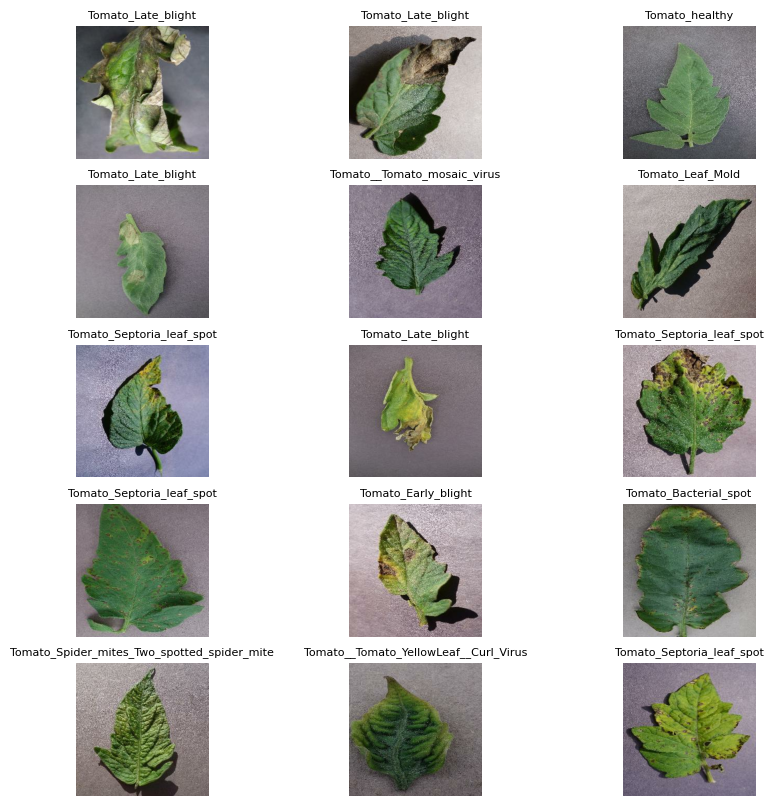

In [11]:
# Visualizing some images and their labels

plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=8)
        plt.axis("off")


# Splitting our dataset into a training and test/val set

Since we are using a tensorflow pipeline we can not use the "train.test.split" method from sk.learn, we will use the alternatif as metioned below

In [12]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [13]:
train_size = 0.8
len(dataset)*train_size

400.8

In [14]:
# Taking 80% of our batches for training the model by using the .take method

train_ds = dataset.take(200)
len(train_ds)

200

In [15]:
# Taking the remainding 20% for test sets by usking the .skip method

test_ds = dataset.skip(200)
len(test_ds)

301

After we have taken 20% for our test sets, we will split these batches (100) into a validation set and a test set

In [16]:
val_size=0.1
len(dataset)*val_size

50.1

In [17]:
val_ds = test_ds.take(25)
len(val_ds)

25

In [18]:
test_ds = test_ds.skip(25)
len(test_ds)

276

In [19]:
# Creating a nice looking python fucntion for using this method on any dataset we want

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split* ds_size)
    val_size = int(val_split* ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
# Calling our function on our dataset

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Confirming the sizes

In [21]:
len(train_ds)

400

In [22]:
len(val_ds)

50

In [23]:
len(test_ds)

51

# Preprocessing our datasets




In [24]:
# cache() : Keeping the images into memory after reading them, to make it easier to use them (again) later
# shuffle() : Randomly shuffles the examples in the datasets -> reduces bias, avoids overfitting
# prefetch : Allows the data loading and preprocessing to happen asynchronously while the model is training or evaluating -> Faster results, less waitingt ime
# prefetch -> tf.data.AUTOTUNE : automatically determines an optimal buffer size based on available disk size/system resources. (While the GPU is training a specific batch, the CPU will in the meantime be used to already load and preprocess the next batch)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
# Creating a "resize_and_rescale" layer that we will need later on in our model to bring the images back to their original dimensions

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [26]:
'''def random_brightness(x):
    x = tf.expand_dims(x, axis=0)  # Omvormen naar een rank 1 tensor
    return tf.image.stateless_random_brightness(x, max_delta=0.95, seed=seed)

def random_contrast(x):
    x = tf.expand_dims(x, axis=0)  # Omvormen naar een rank 1 tensor
    return tf.image.stateless_random_contrast(x, lower=0.1, upper=0.9) '''


'def random_brightness(x):\n    x = tf.expand_dims(x, axis=0)  # Omvormen naar een rank 1 tensor\n    return tf.image.stateless_random_brightness(x, max_delta=0.95, seed=seed)\n\ndef random_contrast(x):\n    x = tf.expand_dims(x, axis=0)  # Omvormen naar een rank 1 tensor\n    return tf.image.stateless_random_contrast(x, lower=0.1, upper=0.9) '

# Data Augmentation

In [27]:
seed = 22

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2, seed=None)
])

# Building the first model ourselves - Baseline Model

In [28]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
])


model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

# Defining our Optimizer and Loss function and how we want to measure our accuracy

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the Network

In [31]:
model.fit(
    train_ds,
    epochs=epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
400/400 [==============================] - 213s 521ms/step - loss: 1.7419 - accuracy: 0.3706 - val_loss: 1.3946 - val_accuracy: 0.5169
Epoch 2/5
400/400 [==============================] - 202s 505ms/step - loss: 1.1398 - accuracy: 0.5929 - val_loss: 0.9325 - val_accuracy: 0.6725
Epoch 3/5
400/400 [==============================] - 195s 487ms/step - loss: 0.8200 - accuracy: 0.7182 - val_loss: 0.9388 - val_accuracy: 0.7000
Epoch 4/5
400/400 [==============================] - 199s 497ms/step - loss: 0.6521 - accuracy: 0.7745 - val_loss: 0.5879 - val_accuracy: 0.7881
Epoch 5/5
400/400 [==============================] - 199s 497ms/step - loss: 0.4954 - accuracy: 0.8311 - val_loss: 0.7925 - val_accuracy: 0.7550


In [32]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 12s 124ms/step - loss: 0.7673 - accuracy: 0.7531


In [33]:
scores

[0.7672580480575562, 0.7530637383460999]

# Visualizing and plotting all of the epochs of the training 

By "equaling" your model.fit to a variable (for example: history), you will be able to see and plot all of the losses and accuracys during the different epochs

In [ ]:
#history

In [36]:
#history.params

In [ ]:
#history.history.keys()

In [ ]:
#acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

#loss = history.history['loss']
#val_loss = history.history['val_loss']

In [ ]:
'''plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label= 'Traininng Accuracy')
plt.plot(range(epochs), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label= 'Traininng Loss')
plt.plot(range(epochs), val_loss, label= 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

## Begint al bij 0.9+ omdat 2de keer getraind is'''

# Predicting images

first image to predict
Actual label: Tomato_healthy
1/1 [==============================] - 0s 123ms/step
predictend label: Tomato_healthy


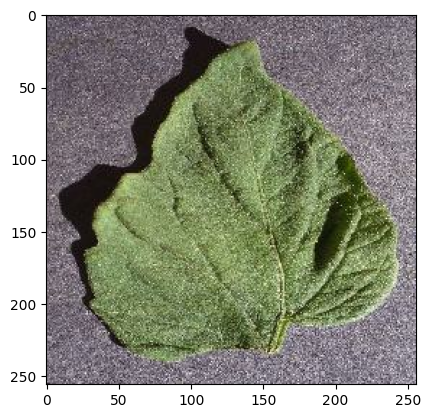

In [46]:
# By running our model on a (specific) image, the model will ouput a probability of belonging to that class for every class

import numpy as np

for image_batch, label_batch in dataset.take(1):

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("Actual label:", class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("predictend label:", class_names[np.argmax(batch_prediction[0])]) # Outputting the highest probability of all the outputed probs per class

In [48]:
# Fucntion that takes our model and an image as an input and outputs the predicted class and the confidence score

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


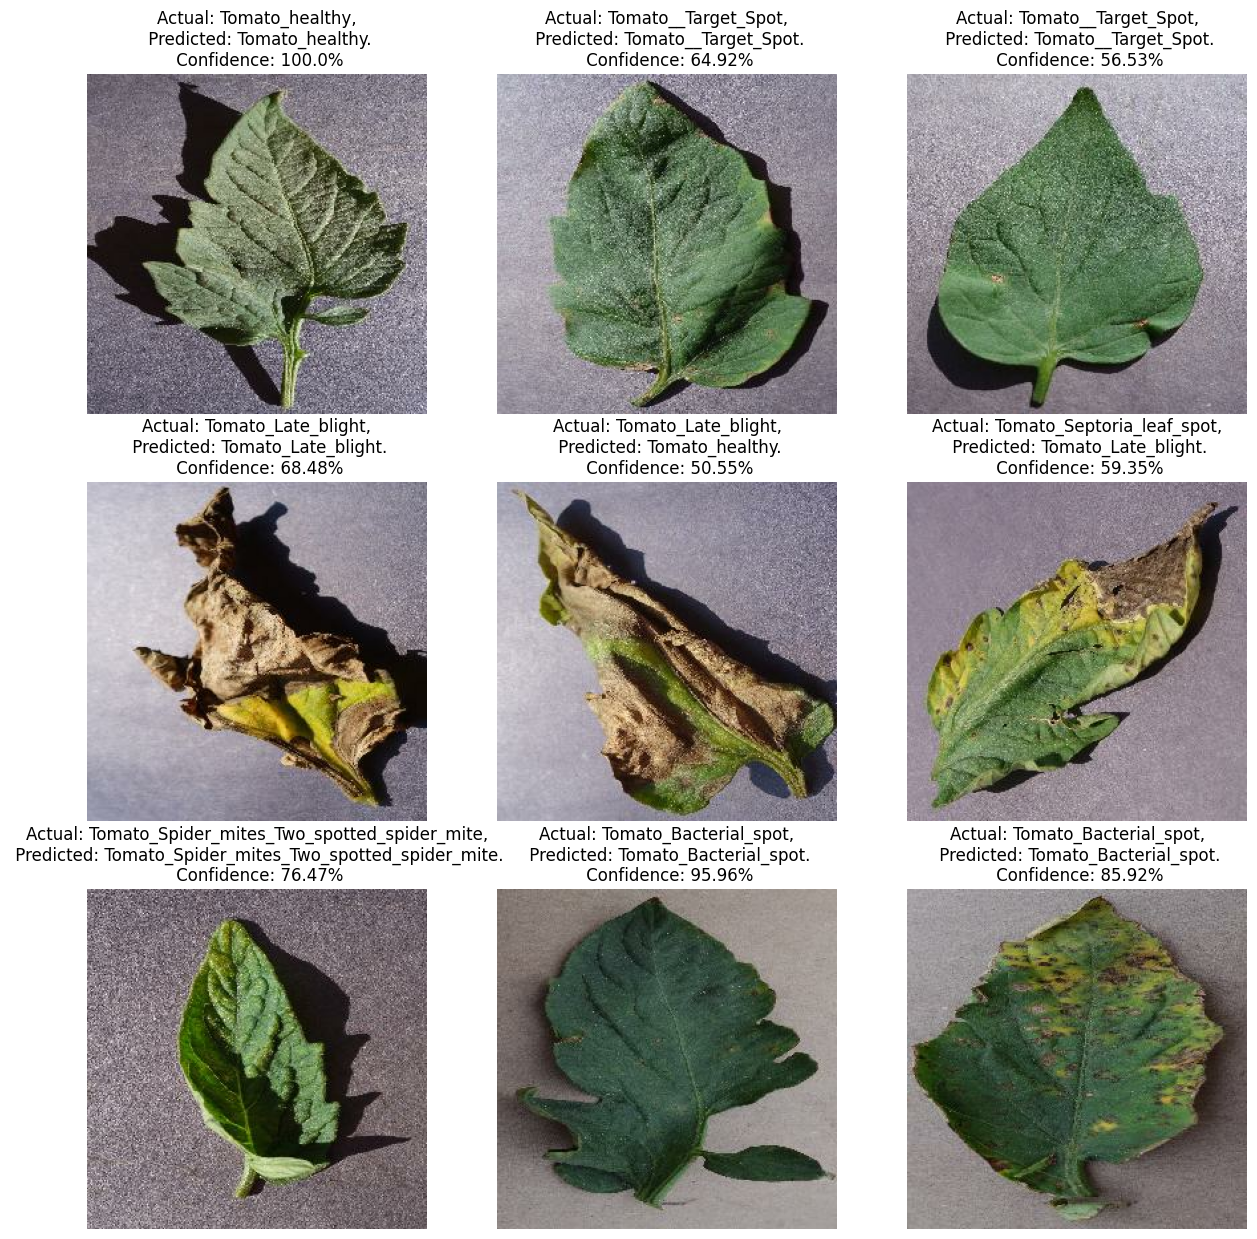

In [50]:
# Predicting the classes for multiple images at the same time (by ysing our function) 

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving our Baseline Models

Part of the plan of the project is to build a webserver that we will deploy to the cloud using Google Cloud and making use of tf.serving, by making use of tf.serving we or the users themselves will be able to choose wich model will be used to make the prediction. 

Trough tf.serving it is also possible to deploy new, untested Beta models to the cloud for a specific group of users without disturbing the other/normal users which are using an other/normal model. 

tf.serving provides quick and easy to integrate switching between models and more 

In [ ]:
# Google Colab 
#import os

#os.makedirs("models", exist_ok=True)

In [ ]:
#from google.colab import files

#model_version = "Model_1"
#model.save(f"models/{model_version}")

#files.download(f"models/{model_version}")

In [51]:
# Jupyter Lab/Notebook 

model_version=1 # Baseline model 
model.save(f"./Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Saved_Models/1/assets


INFO:tensorflow:Assets written to: ./Saved_Models/1/assets


# Trying to improve our accuracy by building a Transformers Model 

**Make sure to chek out the different available models and their performances/statistics**

https://keras.io/api/applications/#usage-examples-for-image-classification-models 

# InceptionV3 Transformers Model 

In [64]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Defining a function to download and use our First transformers model - InceptionV3 

def get_model():

    '''tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",'''
    
    Inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(Image_size, Image_size, Channels)) # Input must be three integers, without batch size 

    for layer in Inception_model.layers:
        layers.trainable = False

    Inception_model_output = Inception_model.output

    x = Flatten()(Inception_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)

    InceptionV3_model = Model(inputs=Inception_model.input, outputs=x)
    return InceptionV3_model

# Defining the Optimizer, Loss and Accuracy measurements for our Inception Model

In [70]:
model = get_model()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             optimizer="sgd",
             metrics=["accuracy"])

In [ ]:
model.summary()

# Training the model 

In [72]:
from keras.callbacks import EarlyStopping as ES

# By using ES (Early Stopping), the model will stop training whenever it doesn't improve anymore

history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=3,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)]) 

Epoch 1/3
400/400 [==============================] - 968s 2s/step - loss: 0.0149 - accuracy: 0.9966 - val_loss: 0.0199 - val_accuracy: 0.9919
Epoch 2/3
400/400 [==============================] - 969s 2s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 0.9950
Epoch 3/3
400/400 [==============================] - 956s 2s/step - loss: 5.5634e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9937


Since the InceptionV3 is a really big network with over 50 000 000 parameters, I have decided to only train the network for 3 epochs. My intention was to train the network for 10 epochs but while I was training it, I saw that I was already having a validation accuracy score of over 0.95 after just 2 epochs. 

You have to take into consideration that this is the reason why the models performance is immedietly almost perfect, because it is actually the second time I have trained it, since it took quite some time I'm not gonna restart the process which I will declare why not in a moment. On the other hand the previous "training" was only at epoch 150 of the second epoch which is eventually not far at all, the accuracy scores back then were already above 0.94-0.95 

In [73]:
# Evaluating the model

scores = model.evaluate(test_ds)

51/51 [==============================] - 30s 593ms/step - loss: 0.0067 - accuracy: 0.9982


As you can see our validation accuracies as well as our test set accuracy is almost perfect, even with 10 different classes/labels 

# Visualizing and plotting the training 

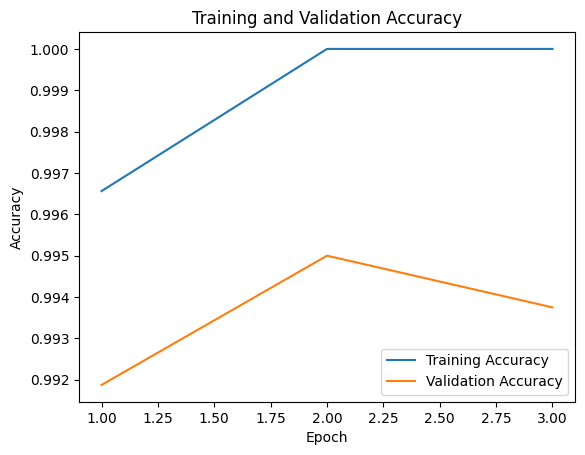

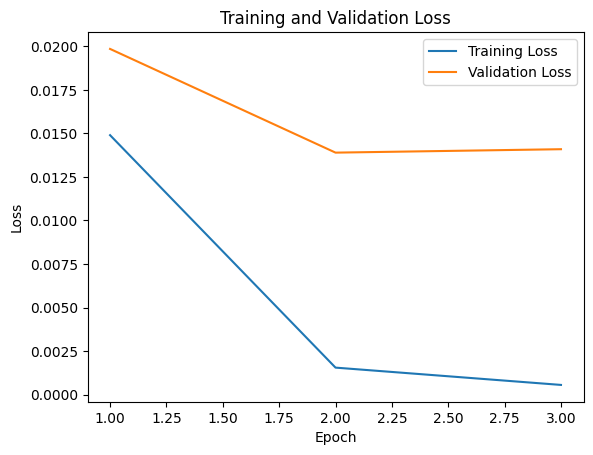

In [80]:
import matplotlib.pyplot as plt

# Haal de accuracies en losses op uit het history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Maak een plot van de accuracies
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Maak een plot van de losses
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Making Predcitions on our dataset and ensuring that our model works 

1/1 [==============================] - 0s 43ms/step


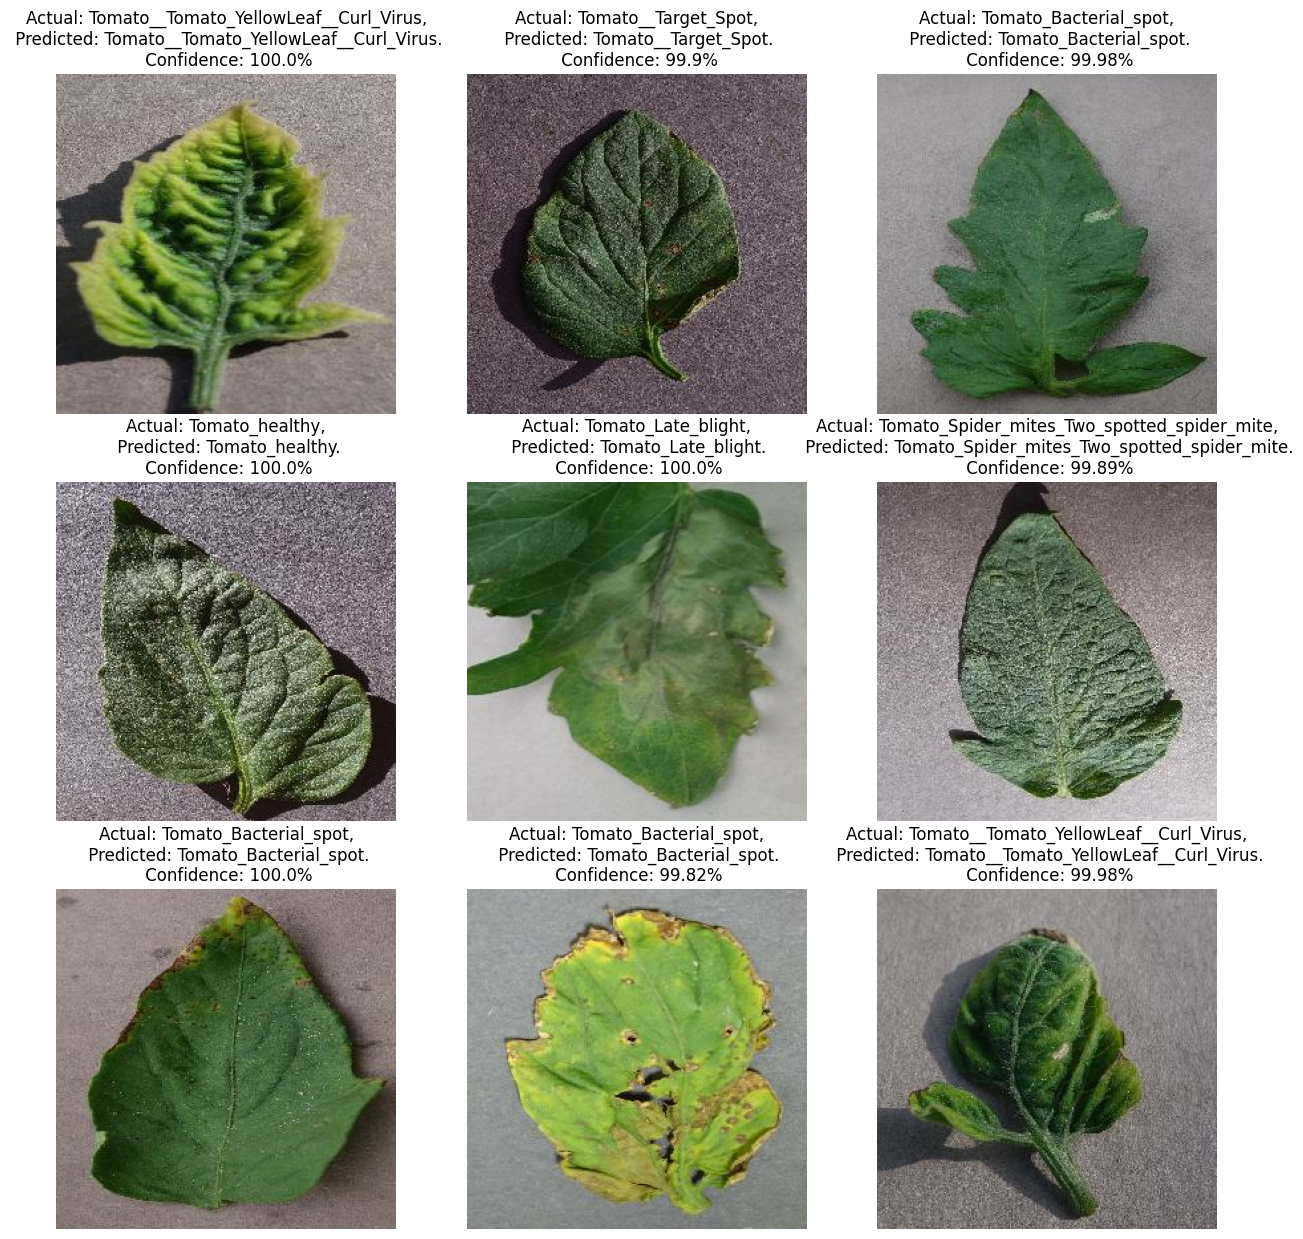

In [86]:
# Same ss previously we're predicting the classes for multiple images at the same time (by again using the predict function) 

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

As you can see we will "always" have a correct prediction, at least i have refreshed it around 10x times and never got a wrong one. Also you will notice that by using this model our confidence score is "always" around 100 (certainly sure), I'm putting this between quotes because in all of the times I've refreshed it, I had 1 (still correct classification) with only a confidence score of around 65%

In [87]:
# Saving our InceptionV3 Model

model_version=2 # InceptionV3 model 
model.save(f"./Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Saved_Models/2/assets


INFO:tensorflow:Assets written to: ./Saved_Models/2/assets


# Conclusion of the InceptionV3 Transformers Model 

Altough the model's performance is incredibly, it might not be a good fit for our actually user. This is because the model's computational time is relative long compared to much smaller networks. 

**Concluding from our problem statement,** I think it is logically to think that a model with a +0.85 accuracy performance but a much shorter computational time is more preferred over mostly of the farmers/end users who will eventually use our application. 

# MobileNetV3 Transformers Model

MobileNetV3 is a lightweight deep learning architecture designed for mobile and embedded devices. It incorporates efficient building blocks such as depthwise separable convolutions and linear bottlenecks to reduce computational complexity while maintaining high accuracy. The trade-off that it makes between the computational time and accuracy in comparison with the InceptionV3 Model is amazing. MobileNetV3 has only around 5 million parameters and is widely used for on-device computational tasks. 

In [109]:
from tensorflow.keras.applications import MobileNetV3Small
from keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Defining a function to download and use our second transformers model - MobileNetV3Small 
# https://keras.io/api/applications/mobilenet/ 

def get_model():

    '''tf.keras.applications.MobileNetV3Small(
    input_shape=None,
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,  ###
    classifier_activation="softmax",
    include_preprocessing=True,
)'''
# As you can see the MobileNet has from default added dropout_layers, we will train the model with and without these dropout layers 
# Also since we have done the preprocessing ourselves, it may be better to turn this off 
    
    MobileNet_model = MobileNetV3Small(weights='imagenet', include_preprocessing=False, dropout_rate=0.4, include_top=False, input_shape=(Image_size, Image_size, Channels)) # Input must be three integers, without batch size 

    for layer in MobileNet_model.layers:
        layers.trainable = False

    MobileNet_model_output = MobileNet_model.output

    x = Flatten()(MobileNet_model_output)
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names), activation='softmax')(x)

    MobileNetV3_model = Model(inputs=MobileNet_model.input, outputs=x)
    return MobileNetV3_model

# Defining Optimization, Loss and Accuracy 

In [110]:
model = get_model()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             optimizer="sgd",
             metrics=["accuracy"])

In [ ]:
model.summary()

# Training the MobileNet Transformers Model

In [93]:
from keras.callbacks import EarlyStopping as ES

# By using ES (Early Stopping), the model will stop training whenever it doesn't improve anymore

history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=3,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)]) 

Epoch 1/3
400/400 [==============================] - 131s 323ms/step - loss: 0.4372 - accuracy: 0.8814 - val_loss: 2.5084 - val_accuracy: 0.3719
Epoch 2/3
400/400 [==============================] - 127s 317ms/step - loss: 0.0116 - accuracy: 0.9976 - val_loss: 0.6248 - val_accuracy: 0.7831
Epoch 3/3
400/400 [==============================] - 126s 315ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2364 - val_accuracy: 0.9187


As you can see by using the Mobilenet architecture the model has also after just 3 epochs an val accuracy of +0.9, takink it again into consideration that with the Inception Model it was actually "the second" (half training) time we were training it, I guess that with just training it 1 time for 3 epochs it would have been around 0.97-0.98

But this went a lot faster! as you can see did the Inception Model take 2s/step (we don't know the actual ms's) and our MobileNet only takes 315ms! which is already 6x times faster + taking into consideration that the chances it would have been low to the 2/s are also smaller, so it is 6x faster AT LEAST! It felt like it was 10-15x as fast... 

**This is a very good trade-off between computational time and accuracy!** Our accuracy is still above 90% but our reaction time has increased 6 times (probably more)

Since we do now have some **variance** in our model we could now try training it again with a higher dropout rate and or could try other methods, to make our model more robust and less **overfitted** 

In [113]:
# I have now chanched the dropout rate from 0.2 to 0.4 and will train the model again for 3 epochs 

# I have chosen to start the training again from start in stead of continueing from the previous training 
# and using the already initiliazed/found parameters, this way we can really see the difference it makes from start

history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=3,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)]) 

Epoch 1/3
400/400 [==============================] - 125s 311ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2030 - val_accuracy: 0.9287
Epoch 2/3
400/400 [==============================] - 124s 309ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0865 - val_accuracy: 0.9719
Epoch 3/3
400/400 [==============================] - 126s 313ms/step - loss: 8.9940e-04 - accuracy: 1.0000 - val_loss: 0.0508 - val_accuracy: 0.9875


I decided to train the model 2x times on 3 epochs each with each a dropout rate of 0.4

As you can see, altough our training accuracy is still 1 (which is not directly bad, but the changes are just higher that this will be (a little) overfitted), we do have a big improvement on our validation accuracy and thus reduced our variance. 

We will now again train the architecture as we did the first time, but now afterwards we will change the dropout rate and re-train the model on the already initialized parameters and weights. 

In [114]:
# Evaluating the model

scores = model.evaluate(test_ds)

51/51 [==============================] - 5s 92ms/step - loss: 0.0389 - accuracy: 0.9877


# Visualizing and plotting the Training

The first visualization is from the model of the first time I trained it with a 0.2 dropout_rate, be aware that the validation accuracy may differ from different times you have trained it, it takes the data to predict on randomly so this will always change a little

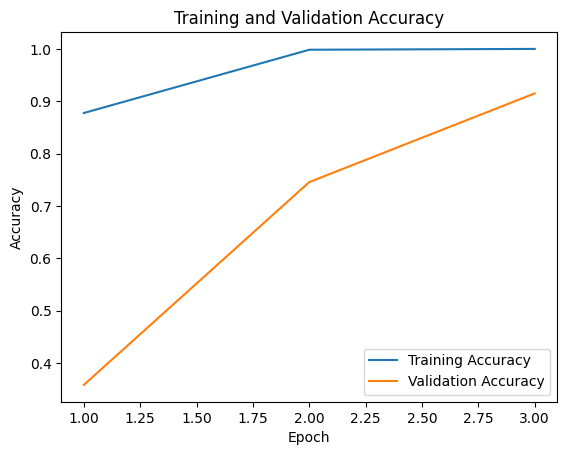

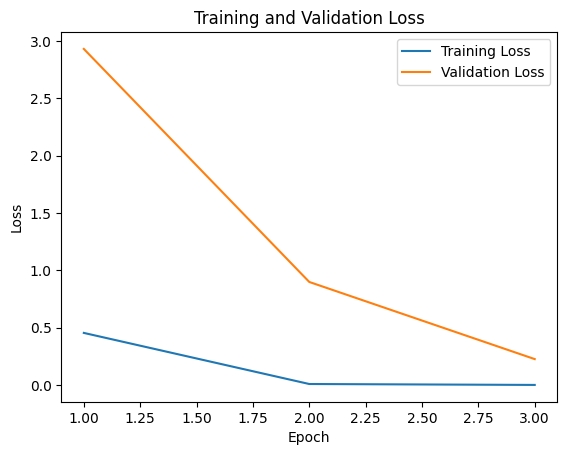

In [108]:
import matplotlib.pyplot as plt

# Haal de accuracies en losses op uit het history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Maak een plot van de accuracies
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Maak een plot van de losses
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

The second visualization below is the plotting of the second time I trained the second model (dropout_rate of 0.4), that's why it is already starting above an accuracy of 90%, the first training of this model will be quite similar to the performance of the first model, with a little less accuracy, but also little less variance 

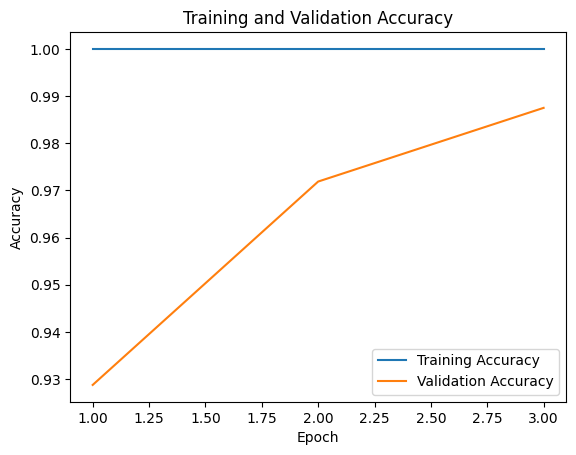

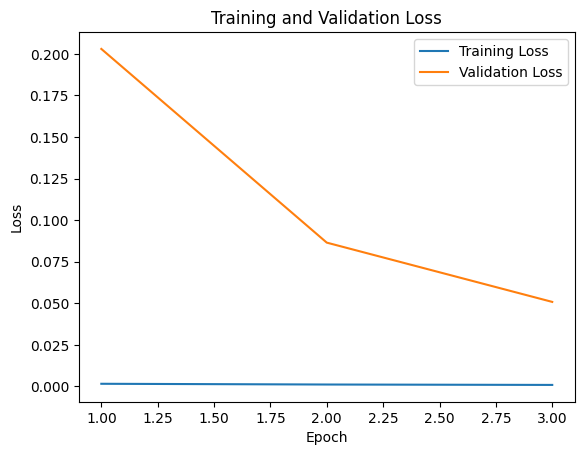

In [115]:
import matplotlib.pyplot as plt

# Haal de accuracies en losses op uit het history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Maak een plot van de accuracies
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Maak een plot van de losses
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Making the predictions on our dataset

1/1 [==============================] - 0s 17ms/step


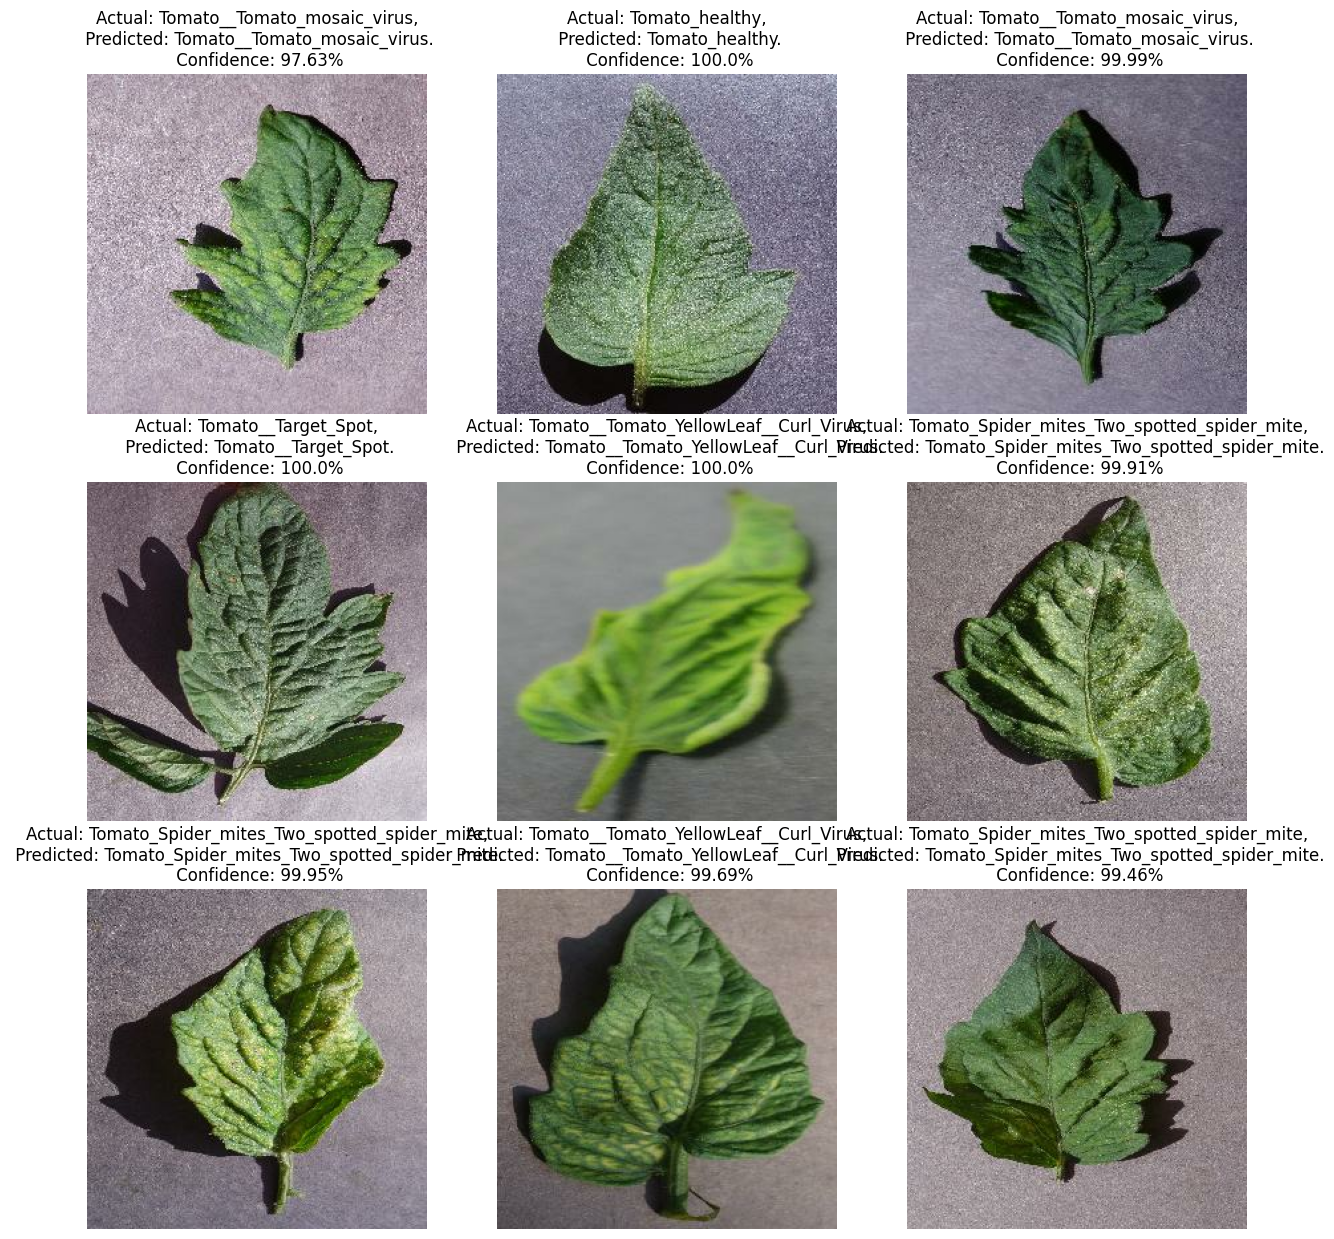

In [116]:
# Same ss previously we're predicting the classes for multiple images at the same time (by again using the predict function) 

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [117]:
# Saving our MobileNetV3 Model

model_version=3 # MobileNetV3 model 
model.save(f"./Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Saved_Models/3/assets


INFO:tensorflow:Assets written to: ./Saved_Models/3/assets


# Conclusion of the MobileNetV3 Transformers Model 

After only training the MobileNet model for 2 times, 3 epochs each, which still only took a fraction of the time needed to train to InceptionV3 Model, we have achieved an accuracy of +98% on the test data set, while keeping the computational time low. 

Considering the tradeoff that we made between computation time and accuracy, altough you can't really call this a trade-off because we just have reduced the time needed to train the model and our accuracy is almost as good as the Inception model, it is clearly that our best performing model, and thus the model that we will use in our application will be the MobileNet model. On top of that, of maybe even more important, we have the fact that the MobileNet is specifically designed to perform well and fast on devices such as your mobile phone and not taking in too much time or memory by using or downloading it. 